# Generating fake Nature abstracts

In this practical, the goal is to produce fake Nature articles. The inspiration comes from the work done by Alessandro Trevisan and his students in detecting "bullshit" in academic writing. No doubt a difficult task, and a never-ending stuggle.

In the `abstracts/real.txt` file, there are 5 **real** abstracts taken from Nature articles. The first goal is to have `gpt-4o-mini` produce some fake abstracts. The next stage is to see if `gpt-4o` can tell the difference. We will then see if _**we**_ can tell the difference, and whether there is anything we can do to bring the generated abstracts closer to the real abstracts.

In [1]:
from openai import OpenAI
import dotenv
import os

import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

from jinja2 import Environment, FileSystemLoader, select_autoescape
from typing import Any

from transformers import AutoModel, AutoTokenizer
import torch

# supress every warning
import warnings
warnings.filterwarnings("ignore")

/home/ryan/Accelerate/Website/winter-school-llms/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = OpenAI()

## Generating fake abstracts
First we load the real abstracts to take a look.

In [3]:
with open('abstracts/real.txt', "r") as f:
    real_abstracts = f.read().split("\n\n")

print(real_abstracts[0])

A goal of neuroscience is to obtain a causal model of the nervous system. The recently reported whole-brain fly connectome specifies the synaptic paths by which neurons can affect each other, but not how strongly they do affect each other in vivo. To overcome this limitation, we introduce a combined experimental and statistical strategy for efficiently learning a causal model of the fly brain, which we refer to as the ‘effectome’. Specifically, we propose an estimator for a linear dynamical model of the fly brain that uses stochastic optogenetic perturbation data to estimate causal effects and the connectome as a prior to greatly improve estimation efficiency. We validate our estimator in connectome-based linear simulations and show that it recovers a linear approximation to the nonlinear dynamics of more biophysically realistic simulations. We then analyse the connectome to propose circuits that dominate the dynamics of the fly nervous system. We discover that the dominant circuits in

Now we need to figure out a way to generate fake abstracts. We create both a system and a user prompt.

**System prompt** The system prompt should direct the model to produce a fake abstract on a topic given by the user.

**User prompt** The user prompt should just be a topic.

We will use Jinja to create the prompts. Create a new directory and add the two prompts.

In [4]:
def load_template(template_filepath: str, arguments: dict[str, Any]) -> str:
    env = Environment(
        loader=FileSystemLoader(searchpath='./'),
        autoescape=select_autoescape()
    )
    template = env.get_template(template_filepath)
    return template.render(**arguments)

In [5]:
generation_system_prompt = load_template("prompts/system.jinja",{})
generation_user_prompt = load_template(
    "prompts/user.jinja",
    {
        "topic": "Panda foraging in subsaharan Africa, and impact on the local polar bear population",
    }
)

print(generation_system_prompt)
print(generation_user_prompt)

You will be given a topic from the user. You are to write an original Nature article abstract about the topic.
Do not write a title, authors, or any other article text. Write only the abstract.
The abstract should be in English.
The abstract should be a continuous paragraph between 150 and 250 words.
It is important that the abstract is scientifically feasible.

Here is a new topic:

Panda foraging in subsaharan Africa, and impact on the local polar bear population


In [6]:
def chat_response(system_prompt, user_prompt, model, temperature) -> str:
    client = OpenAI()

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=temperature,
        max_tokens=400
    ).choices[0].message.content

    return response

In [8]:
fake_abstract = chat_response(generation_system_prompt, generation_user_prompt, "gpt-4o-mini", 0.2)
print(fake_abstract)

The introduction of giant pandas (Ailuropoda melanoleuca) into sub-Saharan Africa presents a unique ecological scenario, particularly concerning its impact on local polar bear (Ursus maritimus) populations. This study investigates the foraging behaviors of pandas in a non-native environment, focusing on their dietary adaptations and resource utilization in the diverse ecosystems of sub-Saharan Africa. Utilizing a combination of field observations and ecological modeling, we assess how the presence of pandas influences local flora and fauna, particularly in relation to the polar bear population, which is typically adapted to Arctic conditions. Preliminary findings suggest that panda foraging habits, primarily centered around bamboo, may inadvertently alter the availability of food resources for polar bears, particularly in regions where climate change has already impacted their traditional hunting grounds. Additionally, the competition for resources between these two species, albeit in 

We now need to produce 5 new abstracts. It would be very useful if we could actually produce articles on similar topics to those in our real abstracts. We will therefore use `gpt-4o` to try and extract single sentence from each abstract.

In [9]:
def extract_topic(abstract):
    extraction_system_prompt = load_template("prompts/extraction_system.jinja",{})
    extraction_user_prompt = load_template(
        "prompts/extraction_user.jinja",
        {
            "abstract": abstract,
        }
    )

    response = chat_response(extraction_system_prompt, extraction_user_prompt, "gpt-4o-mini", 0.2)

    return response

In [10]:
topic_sentence = extract_topic(fake_abstract)
topic_sentence

'Giant pandas in sub-Saharan Africa and their ecological impact on polar bears.'

Great. Now we can do this for all of our real abstracts:

In [11]:
topic_sentences = [extract_topic(abstract) for abstract in real_abstracts]
topic_sentences

['Causal modeling of the fly brain using connectome data and experimental strategies.',
 'Long-term health impacts of tropical cyclones on mortality in the contiguous United States.',
 'Investigation of haematopoiesis in Down syndrome using multi-omic approaches.',
 'Innovative H2-based method revolutionizes sustainable alloy production and processing.',
 'Three-dimensional wave breaking significantly alters steepness and air-sea exchange dynamics.']

Comparing these with the original abstracts seems OK!

Now we can feed these topic sentences into our first `gpt-4o-mini` agent and see how it does.

In [12]:
def generate_abstract(topic):
    generation_system_prompt = load_template("prompts/system.jinja",{})
    generation_user_prompt = load_template(
        "prompts/user.jinja",
        {
            "topic": topic,
        }
    )

    fake_abstract = chat_response(generation_system_prompt, generation_user_prompt, "gpt-4o-mini", 0.2)

    return fake_abstract

In [13]:
generated_abstracts = [generate_abstract(topic) for topic in topic_sentences]

In [14]:
print(topic_sentences[0])
print("-"*10)
print(generated_abstracts[0])
print("-"*10)
print(real_abstracts[0])

Causal modeling of the fly brain using connectome data and experimental strategies.
----------
Understanding the causal relationships within the complex neural circuitry of the fly brain is pivotal for elucidating the mechanisms underlying behavior and cognition. This study employs a comprehensive approach that integrates connectome data with experimental strategies to construct a causal model of the Drosophila melanogaster brain. Utilizing high-resolution connectomic mapping, we delineate the intricate synaptic connections among neurons, providing a structural framework for our causal analysis. We then apply advanced computational techniques, including graph theory and machine learning algorithms, to infer causal relationships from the connectomic data. Experimental validation is achieved through targeted manipulation of specific neural circuits using optogenetics and calcium imaging, allowing us to observe resultant behavioral changes in real-time. Our findings reveal key nodes and p

But how can we really compare these? We generate embeddings of the abstracts.

In [15]:
def get_embedding(texts : list, method = "openai"):
    match method:
        case "openai":
            embeddings = client.embeddings.create(
                model="text-embedding-3-small",
                input=texts
            )
            embeddings = [embedding.embedding for embedding in embeddings.data]

            return np.array(embeddings)
        
        case "bert":
            model_checkpoint = "distilbert/distilbert-base-uncased"

            model = AutoModel.from_pretrained(model_checkpoint)
            tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

            tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
            with torch.no_grad():
                embeddings = model(**tokens).last_hidden_state[:, 0, :].detach().numpy()

            return embeddings
        
        case _:
            raise ValueError("Invalid method")

In [16]:
real_embeddings = get_embedding(real_abstracts)
generated_embeddings = get_embedding(generated_abstracts)

In [17]:
similarity = cosine_similarity(real_embeddings, generated_embeddings)

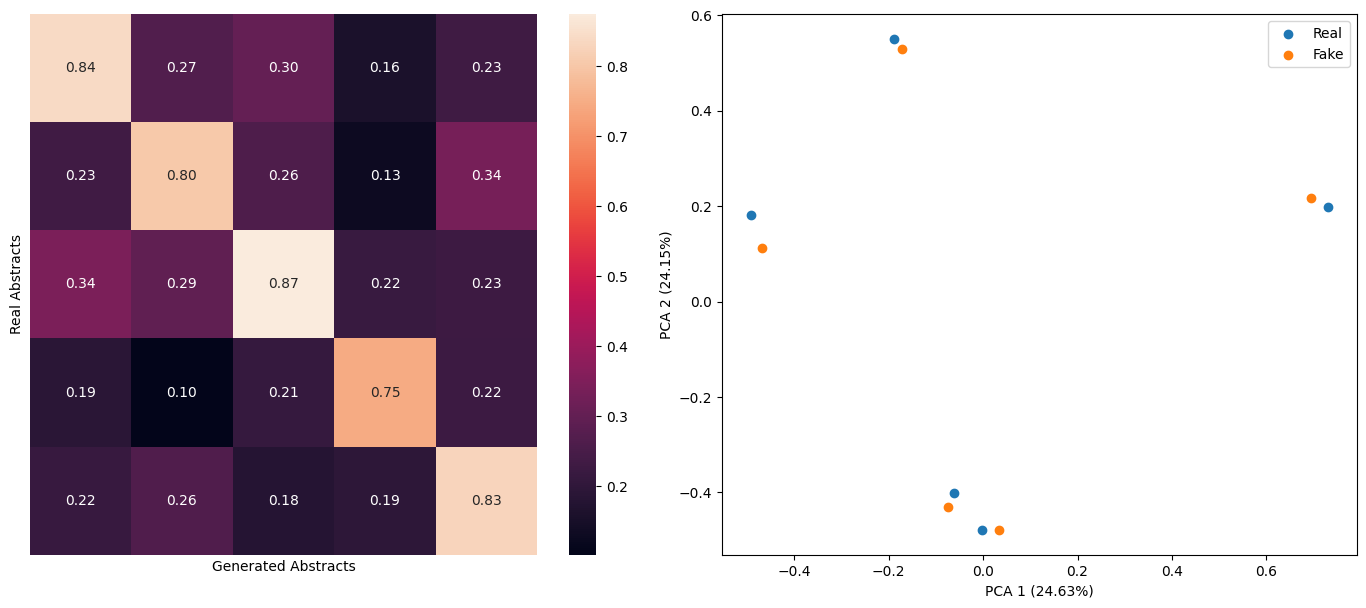

In [18]:
all_embeddings = np.concatenate([real_embeddings, generated_embeddings])

pca = PCA(n_components=2)
pca.fit(all_embeddings)
real_pca = pca.transform(real_embeddings)
fake_pca = pca.transform(generated_embeddings)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout()

# heatmap with names axes and 2sf labels
sns.heatmap(similarity, annot=True, fmt='.2f', xticklabels=False, yticklabels=False, square=False, ax=ax1)
ax1.set_xlabel("Generated Abstracts")
ax1.set_ylabel("Real Abstracts")

ax2.scatter(real_pca[:,0], real_pca[:,1], label="Real")
ax2.scatter(fake_pca[:,0], fake_pca[:,1], label="Fake")
ax2.set_xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax2.set_ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax2.legend()

plt.show()

From this is seems like most of the variance is down to the difference in topic. What if we get 5 abstracts of the same topic? In the file `abstracts/real_same.txt` are 5 articles on the fruit fly connectome. First grab the topic sentences and then generate the samples as before.

In [19]:
with open('abstracts/real_same.txt', "r") as f:
    real_same_abstracts = f.read().split("\n\n")

In [20]:
same_topic_sentences = [extract_topic(abstract) for abstract in real_same_abstracts]
same_topic_sentences

['Causal modeling of the fly brain using connectome data and experimental strategies.',
 'Analysis of the adult fly brain connectome reveals insights into neural network organization.',
 'Modeling the Drosophila brain reveals insights into sensory processing and behavior.',
 'Comprehensive annotation of neuronal classes and cell types in Drosophila brain connectome.',
 'Analysis of Drosophila optic lobe connectome reveals new neuronal cell types and connectivity rules.',
 'Whole brain neuronal wiring diagram created for Drosophila melanogaster connectivity analysis.',
 'Advancements in connectomics enable predictions about neuronal function from structural analysis.',
 'Neural mechanisms of halting in Drosophila during different behavioral contexts.',
 "Visual information processing in Drosophila's navigation system and its neural architecture."]

In [21]:
same_generated_abstracts = [generate_abstract(topic) for topic in same_topic_sentences]

In [22]:
same_real_embeddings = get_embedding(real_same_abstracts)
same_generated_embeddings = get_embedding(same_generated_abstracts)

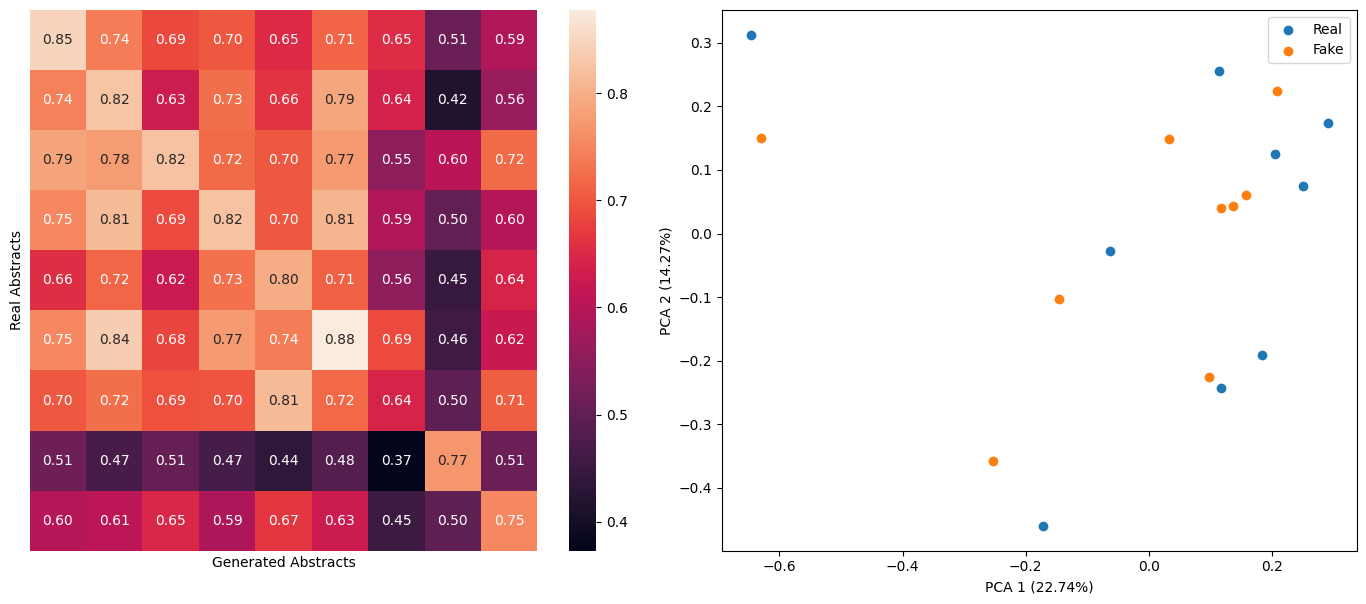

In [23]:
similarity = cosine_similarity(same_real_embeddings, same_generated_embeddings)

all_embeddings = np.concatenate([same_real_embeddings, same_generated_embeddings])

pca = PCA(n_components=2)
pca.fit(all_embeddings)
real_pca = pca.transform(same_real_embeddings)
fake_pca = pca.transform(same_generated_embeddings)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout()

# heatmap with names axes and 2sf labels
sns.heatmap(similarity, annot=True, fmt='.2f', xticklabels=False, yticklabels=False, square=False, ax=ax1)
ax1.set_xlabel("Generated Abstracts")
ax1.set_ylabel("Real Abstracts")

ax2.scatter(real_pca[:,0], real_pca[:,1], label="Real")
ax2.scatter(fake_pca[:,0], fake_pca[:,1], label="Fake")
ax2.set_xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax2.set_ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax2.legend()

plt.show()

Just by looking at the similarity scores of the embeddings and the first two pricipal components, it is quite difficult to spot the difference between the two different styles.

Now contrast this with the haiku generated by Claude, and the real haiku.

In [45]:
with open("haiku/real_haiku_basho.txt", "r") as f:
    real_haikus_basho = f.read().split("\n\n")

with open("haiku/real_haiku_buson.txt", "r") as f:
    real_haikus_buson = f.read().split("\n\n")

with open("haiku/real_haiku_issa.txt", "r") as f:
    real_haikus_issa = f.read().split("\n\n")

with open("haiku/gpt_haiku.txt", "r") as f:
    fake_haikus = f.read().split("\n\n")

print(real_haikus_basho[0])
print()
print(fake_haikus[0])

real_haikus = real_haikus_basho + real_haikus_buson + real_haikus_issa

all_haikus = real_haikus + fake_haikus
# 1 for real, 0 for fake
targets = [1] * len(real_haikus) + [0] * len(fake_haikus)

# shuffle
# import random
# zipped = list(zip(all_haikus, targets))
# random.shuffle(zipped)

The old pond
a frog jumps in
sound of water

Dawn's first light
a spider weaves anew
its dew-kissed web


In [46]:
fake_haiku_embeddings = get_embedding(fake_haikus)
real_haiku_embeddings = get_embedding(real_haikus)

In [47]:
all_embeddings = np.concatenate([real_haiku_embeddings, fake_haiku_embeddings])

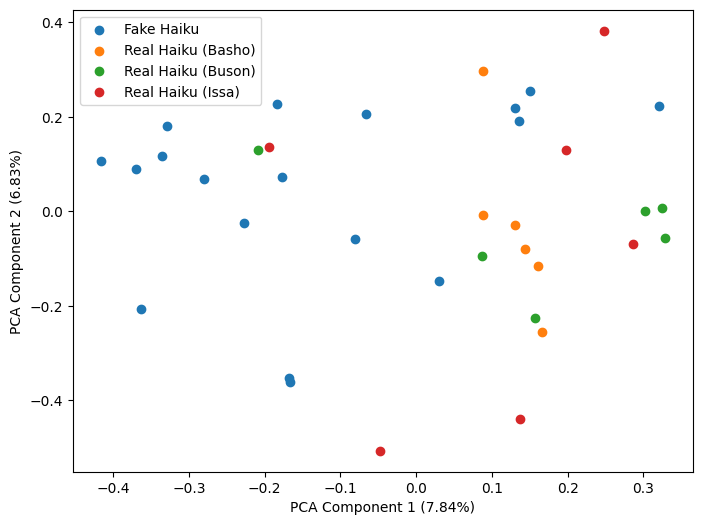

In [48]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
# plot each poet
plt.scatter(pca_embeddings[:len(fake_haikus), 0], pca_embeddings[:len(fake_haikus), 1], label="Fake Haiku")
# basho
plt.scatter(
    pca_embeddings[len(fake_haikus):len(fake_haikus)+len(real_haikus_basho), 0], 
    pca_embeddings[len(fake_haikus):len(fake_haikus)+len(real_haikus_basho), 1],
    label="Real Haiku (Basho)"
)
# buson
plt.scatter(
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho):len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson), 0],
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho):len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson), 1],
    label="Real Haiku (Buson)"
)
# issa
plt.scatter(
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson):, 0],
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson):, 1],
    label="Real Haiku (Issa)"
)

plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.show()

## Using BERT as the embedding model
We've tried using the OpenAI embedding models. But now let's try our old friend, BERT.

In [49]:
fake_embeddings = get_embedding(fake_haikus, method="bert")
real_embeddings = get_embedding(real_haikus, method="bert")

In [51]:
embeddings = np.concatenate([fake_embeddings, real_embeddings])
labels = np.array([0]*len(fake_haikus) + [1]*len(real_haikus))

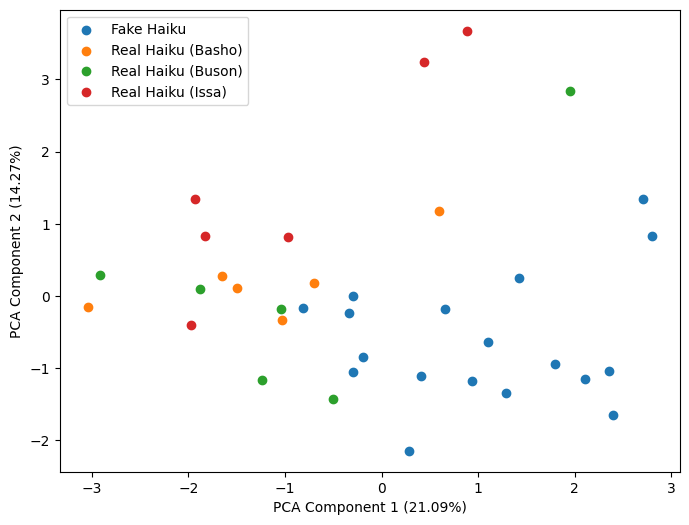

In [52]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
# plot each poet
plt.scatter(pca_embeddings[:len(fake_haikus), 0], pca_embeddings[:len(fake_haikus), 1], label="Fake Haiku")
# basho
plt.scatter(
    pca_embeddings[len(fake_haikus):len(fake_haikus)+len(real_haikus_basho), 0], 
    pca_embeddings[len(fake_haikus):len(fake_haikus)+len(real_haikus_basho), 1],
    label="Real Haiku (Basho)"
)
# buson
plt.scatter(
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho):len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson), 0],
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho):len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson), 1],
    label="Real Haiku (Buson)"
)
# issa
plt.scatter(
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson):, 0],
    pca_embeddings[len(fake_haikus)+len(real_haikus_basho)+len(real_haikus_buson):, 1],
    label="Real Haiku (Issa)"
)

plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.show()

That actually looks a little better.

### With the abstracts

In [53]:
with open('abstracts/real_same.txt', "r") as f:
    real_same_abstracts = f.read().split("\n\n")

In [54]:
same_fake_embeddings = get_embedding(same_generated_abstracts, method="bert")
same_real_embeddings = get_embedding(real_same_abstracts, method="bert")

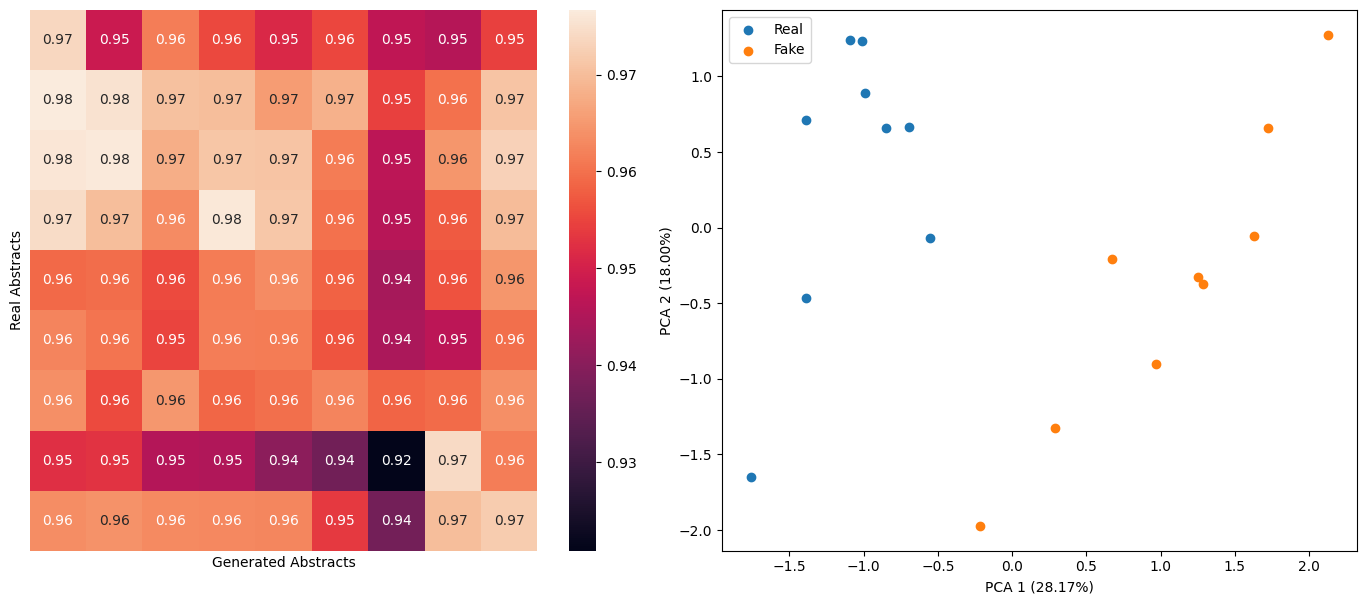

In [55]:
similarity = cosine_similarity(same_real_embeddings, same_fake_embeddings)


all_embeddings = np.concatenate([same_real_embeddings, same_fake_embeddings])

pca = PCA(n_components=2)
pca.fit(all_embeddings)
real_pca = pca.transform(same_real_embeddings)
fake_pca = pca.transform(same_fake_embeddings)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout()

# heatmap with names axes and 2sf labels
sns.heatmap(similarity, annot=True, fmt='.2f', xticklabels=False, yticklabels=False, square=False, ax=ax1)
ax1.set_xlabel("Generated Abstracts")
ax1.set_ylabel("Real Abstracts")

ax2.scatter(real_pca[:,0], real_pca[:,1], label="Real")
ax2.scatter(fake_pca[:,0], fake_pca[:,1], label="Fake")
ax2.set_xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax2.set_ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax2.legend()

plt.show()

Well, well, well...

BERT to the rescue once again. Even though their cosine similarities are all remarkably similar, as we would expect, since they are all papers around the same topic, PCA on those embeddings still yields some valuable results.

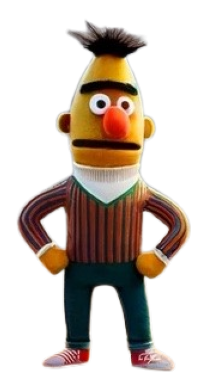

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("bert-alone.png")
plt.imshow(img)
plt.axis('off')
plt.show()